In [1]:
#Identifying GPU Google Colab
#gpu_info = !nvidia-smi
#gpu_info = '\n'.join(gpu_info)
#if gpu_info.find('failed') >= 0:
#  print('Not connected to a GPU')
#else:
#  print(gpu_info)



In [2]:
# Basic Libraries
import pandas as pd
import numpy as np
import sys
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import sklearn
from sklearn.preprocessing import MinMaxScaler # for scaling inputs used in the generator and discriminator
import time



# Tensorflow / Keras
import tensorflow as tf
from tensorflow import keras # for building Neural Networks
from keras.models import Sequential # for assembling a Neural Network model
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, ReLU, LeakyReLU, Dropout, BatchNormalization # adding layers to the Neural Network model
from tensorflow.keras.utils import plot_model, to_categorical # for plotting model diagram
from tensorflow.keras.optimizers import Adam # for model optimization 
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import load_model
import tensorflow_datasets as tfds
import tensorflow_hub as hub

# Visualization
import cv2 # for ingesting images
import matplotlib 
import matplotlib.pyplot as plt # or data visualizationa
import graphviz # for showing model diagram
from PIL import Image

In [3]:
#Configure double GPU for tensorflow

# Define tand get the number os devices. 
#strategy = tf.distribute.MirroredStrategy()
#print('DEVICES AVAILABLE: {}'.format(strategy.num_replicas_in_sync))



In [4]:
#Configuration environment
#os.environ['KAGGLE_USERNAME'] = "rafaelmedina82"# username from the json file
#os.environ['KAGGLE_KEY'] = "e332a88d533c3ea3398f8f24e95c9b0a"# key from the json file

In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

In [6]:
# Load Data

#base_path = '/content/drive/My Drive/data/gan/'
base_path = '/kaggle/working/'
base_path_input = '/kaggle/input/training-64-20images/'

Data = np.load(base_path_input+'dataset_less_128_2 (1).npy')



# shuffle the data
#shuffler = np.random.permutation(len(Data))
#Data = Data[shuffler]

# Batch and shuffle the data
#Data = tf.data.Dataset.from_tensor_slices(Data) \
#.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [7]:
#Define variables and constant

image_size = 64
BATCH_SIZE = 32
n_epochs = 3000

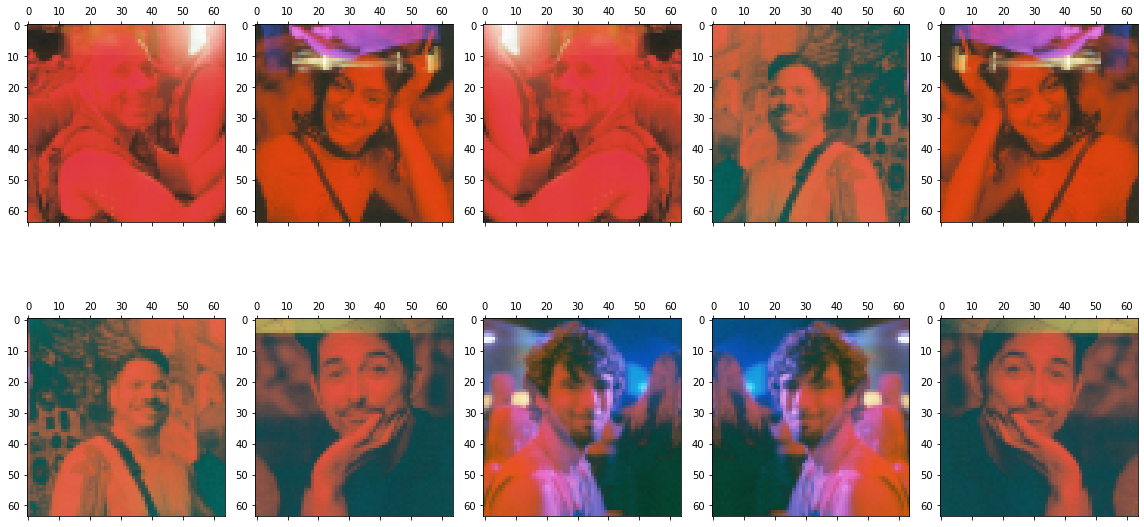

In [8]:
# Display 10 real images
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(16,9), facecolor='white')
n=0
for i in range(0,2):
    for j in range(0,5):
        axs[i,j].matshow(Data[n])
        n=n+1
plt.show() 

In [9]:

# Scaler
scaler=MinMaxScaler(feature_range=(-1, 1))

# Select images that we want to use for model trainng
df_image=Data.copy()
print("Original shape of the data: ", df_image.shape)

# Reshape array
df_image=df_image.reshape(-1, 1)
print("Reshaped data: ", df_image.shape)

# Fit the scaler
scaler.fit(df_image)

# Scale the array
df_image=scaler.transform(df_image)

# Reshape back to the original shape
df_image=df_image.reshape(Data.shape[0], image_size, image_size, 3)
print("Shape of the scaled array: ", df_image.shape)


Original shape of the data:  (20, 64, 64, 3)
Reshaped data:  (245760, 1)
Shape of the scaled array:  (20, 64, 64, 3)


In [10]:
def generator (seed_size):
    model = Sequential (name="generator")
    
    # Hidden Layer 1: Start with 8 x 8 image
    n_nodes = 8 * 8 * 128 # number of nodes in the first hidden layer
    model.add(Dense(n_nodes, use_bias=False, input_dim=seed_size, name='Generator-Hidden-Layer-1'))
    #model.add(BatchNormalization())
    #model.add(LeakyReLU(alpha=0.2, name='Generator-Hidden-Layer-Activation-1'))
    model.add(Reshape((8, 8, 128), name='Generator-Hidden-Layer-Reshape-1'))
    #assert model.output_shape == (None, 8, 8, 128)
    
    # Hidden Layer 2: Upsample to 16 x 16
    model.add(Conv2DTranspose(filters=128, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False, name='Generator-Hidden-Layer-2'))
    #assert model.output_shape == (None, 16, 16, 128)
    #model.add(BatchNormalization())
    model.add(ReLU(name='Generator-Hidden-Layer-Activation-2'))
                              
    # Hidden Layer 3: Upsample to 32 x 32
    model.add(Conv2DTranspose(filters=256, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False, name='Generator-Hidden-Layer-3'))
    #assert model.output_shape == (None, 32, 32, 256)
    #model.add(BatchNormalization())
    model.add(ReLU(name='Generator-Hidden-Layer-Activation-3'))
    
    # Hidden Layer 4: Upsample to 64 x 64
    model.add(Conv2DTranspose(filters=512, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False, name='Generator-Hidden-Layer-4'))
    #assert model.output_shape == (None, 64, 64, 512) 
    #model.add(BatchNormalization())
    model.add(ReLU(name='Generator-Hidden-Layer-Activation-4'))
    
    # Hidden Layer 5: Upsample to 128 x 128
    #model.add(Conv2DTranspose(filters=1024, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False, name='Generator-Hidden-Layer-5'))
    #assert model.output_shape == (None, 128, 128, 1024) 
    #model.add(BatchNormalization())
    #model.add(LeakyReLU(alpha=0.2, name='Generator-Hidden-Layer-Activation-5'))

    # Output Layer (Note, we use 3 filters because we have 3 channels for a color image. Grayscale would have only 1 channel)
    model.add(Conv2D(filters=3, kernel_size=(5,5), activation='tanh', padding='same', use_bias=False, name='Generator-Output-Layer'))
    return model

# Instantiate
seed_size=100 # Our latent space has 100 dimensions. We can change it to any number
gen_model = generator(seed_size)

# Show model summary and plot model diagram
gen_model.summary()
#plot_model(gen_model, show_shapes=True, show_layer_names=True, dpi=400)


Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Generator-Hidden-Layer-1 (De (None, 8192)              819200    
_________________________________________________________________
Generator-Hidden-Layer-Resha (None, 8, 8, 128)         0         
_________________________________________________________________
Generator-Hidden-Layer-2 (Co (None, 16, 16, 128)       409600    
_________________________________________________________________
Generator-Hidden-Layer-Activ (None, 16, 16, 128)       0         
_________________________________________________________________
Generator-Hidden-Layer-3 (Co (None, 32, 32, 256)       819200    
_________________________________________________________________
Generator-Hidden-Layer-Activ (None, 32, 32, 256)       0         
_________________________________________________________________
Generator-Hidden-Layer-4 (Co (None, 64, 64, 512)       32

In [11]:

def discriminator(in_shape=(image_size,image_size,3)):
    model = Sequential(name="Discriminator") # Model
    
    # Hidden Layer 0
    model.add(Conv2D(filters=32, kernel_size=(4,4), strides=(2, 2), padding='same', input_shape=in_shape, name='Discriminator-Hidden-Layer-0'))
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-0'))

    # Hidden Layer 1
    model.add(Conv2D(filters=64, kernel_size=(4,4), strides=(2, 2), padding='same', input_shape=in_shape, name='Discriminator-Hidden-Layer-1'))
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-1'))
    

    # Hidden Layer 2
    model.add(Conv2D(filters=128, kernel_size=(4,4), strides=(2, 2), padding='same', input_shape=in_shape, name='Discriminator-Hidden-Layer-2'))
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-2'))

    
    # Hidden Layer 3
    model.add(Conv2D(filters=256, kernel_size=(4,4), strides=(2, 2), padding='same', input_shape=in_shape, name='Discriminator-Hidden-Layer-3'))
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-3'))

    
    # Flatten and Output Layers
    model.add(Flatten(name='Discriminator-Flatten-Layer')) # Flatten the shape
    model.add(Dropout(0.3, name='Discriminator-Flatten-Layer-Dropout')) # Randomly drop some connections for better generalization
    model.add(Dense(1, activation='sigmoid', name='Discriminator-Output-Layer')) # Output Layer
    
    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
    return model

# Instantiate
dis_model = discriminator()

# Show model summary and plot model diagram
dis_model.summary()
#plot_model(dis_model, show_shapes=True, show_layer_names=True, dpi=400)

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Discriminator-Hidden-Layer-0 (None, 32, 32, 32)        1568      
_________________________________________________________________
Discriminator-Hidden-Layer-A (None, 32, 32, 32)        0         
_________________________________________________________________
Discriminator-Hidden-Layer-1 (None, 16, 16, 64)        32832     
_________________________________________________________________
Discriminator-Hidden-Layer-A (None, 16, 16, 64)        0         
_________________________________________________________________
Discriminator-Hidden-Layer-2 (None, 8, 8, 128)         131200    
_________________________________________________________________
Discriminator-Hidden-Layer-A (None, 8, 8, 128)         0         
_________________________________________________________________
Discriminator-Hidden-Layer-3 (None, 4, 4, 256)       

In [12]:
def def_gan(generator, discriminator):
    
    # don't train the weights of discriminator at this stage.
    discriminator.trainable = False
    
    # Combine
    #with strategy.scope():
    model = Sequential(name="DCGAN") # GAN Model
    model.add(generator) # Add Generator
    model.add(discriminator) # Add Discriminator
    
    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    
    return model


# Instantiate
gan_model = def_gan(gen_model, dis_model)

# Show model summary and plot model diagram
gan_model.summary()
#plot_model(gan_model, show_shapes=True, show_layer_names=True, dpi=400)


Model: "DCGAN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator (Sequential)       (None, 64, 64, 3)         5363200   
_________________________________________________________________
Discriminator (Sequential)   (None, 1)                 694241    
Total params: 6,057,441
Trainable params: 5,363,200
Non-trainable params: 694,241
_________________________________________________________________


In [13]:
def real_samples(n, dataset):
    
    # Samples of real data
    X_train = dataset[np.random.choice(dataset.shape[0], n, replace=True), :]

    # Class labels
    y = np.ones((n, 1))
    return X_train, y
    

In [14]:
def seed_vector(seed_size, n):
    
    # Generate points in the seed space
    seed_input = np.random.randn(seed_size * n)
    
    # Reshape into a batch of inputs for the network
    seed_input = seed_input.reshape(n, seed_size)
    return seed_input
  
    
def fake_samples(generator, seed_size, n):
    
    # Generate points in latent space
    seed_output = seed_vector(seed_size, n)
    
    # Predict outputs (i.e., generate fake samples)
    X_train = generator.predict(seed_output)
    
    # Create class labels
    y = np.zeros((n, 1))
    return X_train, y    


In [15]:

def performance_summary(generator, discriminator, dataset, seed_size, image_size, n_epochs, n=20):
    
    # Get samples of the real data
    x_real, y_real = real_samples(n, dataset)
    # Evaluate the descriminator on real data
    _, real_accuracy = discriminator.evaluate(x_real, y_real, verbose=0)
    
    # Get fake (generated) samples2
    x_fake, y_fake = fake_samples(generator, seed_size, n)
    # Evaluate the descriminator on fake (generated) data
    _, fake_accuracy = discriminator.evaluate(x_fake, y_fake, verbose=0)
    
    # summarize discriminator performance
    print("*** Evaluation ***")
    print("Discriminator Accuracy on REAL images: ", real_accuracy)
    print("Discriminator Accuracy on FAKE (generated) images: ", fake_accuracy)
    
    # Display 6 fake images
    x_fake_inv_trans=x_fake.reshape(-1, 1)
    x_fake_inv_trans=scaler.inverse_transform(x_fake_inv_trans)
    x_fake_inv_trans=x_fake_inv_trans.reshape(n, image_size, image_size, 3)
    
    fig, axs = plt.subplots(3, 3, sharey=False, tight_layout=True, figsize=(image_size,image_size), facecolor='white')
    k=0
    for i in range(0,3):
        for j in range(0,3):
            axs[i,j].matshow(x_fake_inv_trans[k])
            #filename = os.path.join(base_path,f"train-{n_epochs}.png")
            #im = Image.fromarray(x_fake_inv_trans[k])
            #im.save(filename)
            k=k+1
    plt.savefig(base_path+f"train-{n_epochs}.png")
    plt.show() 
    


In [16]:

def train(g_model, d_model, gan_model, dataset, seed_size, image_size, n_batch, n_epochs, n_eval=100):
    
    # batch to train the discriminator will consist of half real and half fake images
    half_batch = int(n_batch / 2)
    
    # enumare epochs 
    for i in range(n_epochs):
    
    # Discriminator training
        # Prep real samples
        x_real, y_real = real_samples(half_batch, dataset)
        # Prep fake (generated) samples
        x_fake, y_fake = fake_samples(g_model, seed_size, half_batch)
        
        # Train the discriminator using real and fake samples
        X, y = np.vstack((x_real, x_fake)), np.vstack((y_real, y_fake))
        discriminator_loss, _ = d_model.train_on_batch(X, y)
    
    # Generator training
        # Get seed values to be used as inputs for the generator
        x_gan = seed_vector(seed_size, n_batch)
        # While we are generating fake samples, 
        # GAN generator model to create examples that resemble the real ones,
        # hence to pass labels corresponding to real samples, i.e. y=1, not 0.
        y_gan = np.ones((n_batch, 1))
        
        # Train the generator via a composite GAN model
        generator_loss = gan_model.train_on_batch(x_gan, y_gan)
        
        # Evaluate the model at every n_eval epochs
        if (i) % n_eval == 0:
            print("Epoch number: ", i)
            print("*** Training ***")
            print("Discriminator Loss ", discriminator_loss)
            print("Generator Loss: ", generator_loss)
            performance_summary(g_model, d_model, dataset, seed_size, image_size, i)


Epoch number:  0
*** Training ***
Discriminator Loss  0.7121825814247131
Generator Loss:  0.6933929920196533
*** Evaluation ***
Discriminator Accuracy on REAL images:  1.0
Discriminator Accuracy on FAKE (generated) images:  0.0


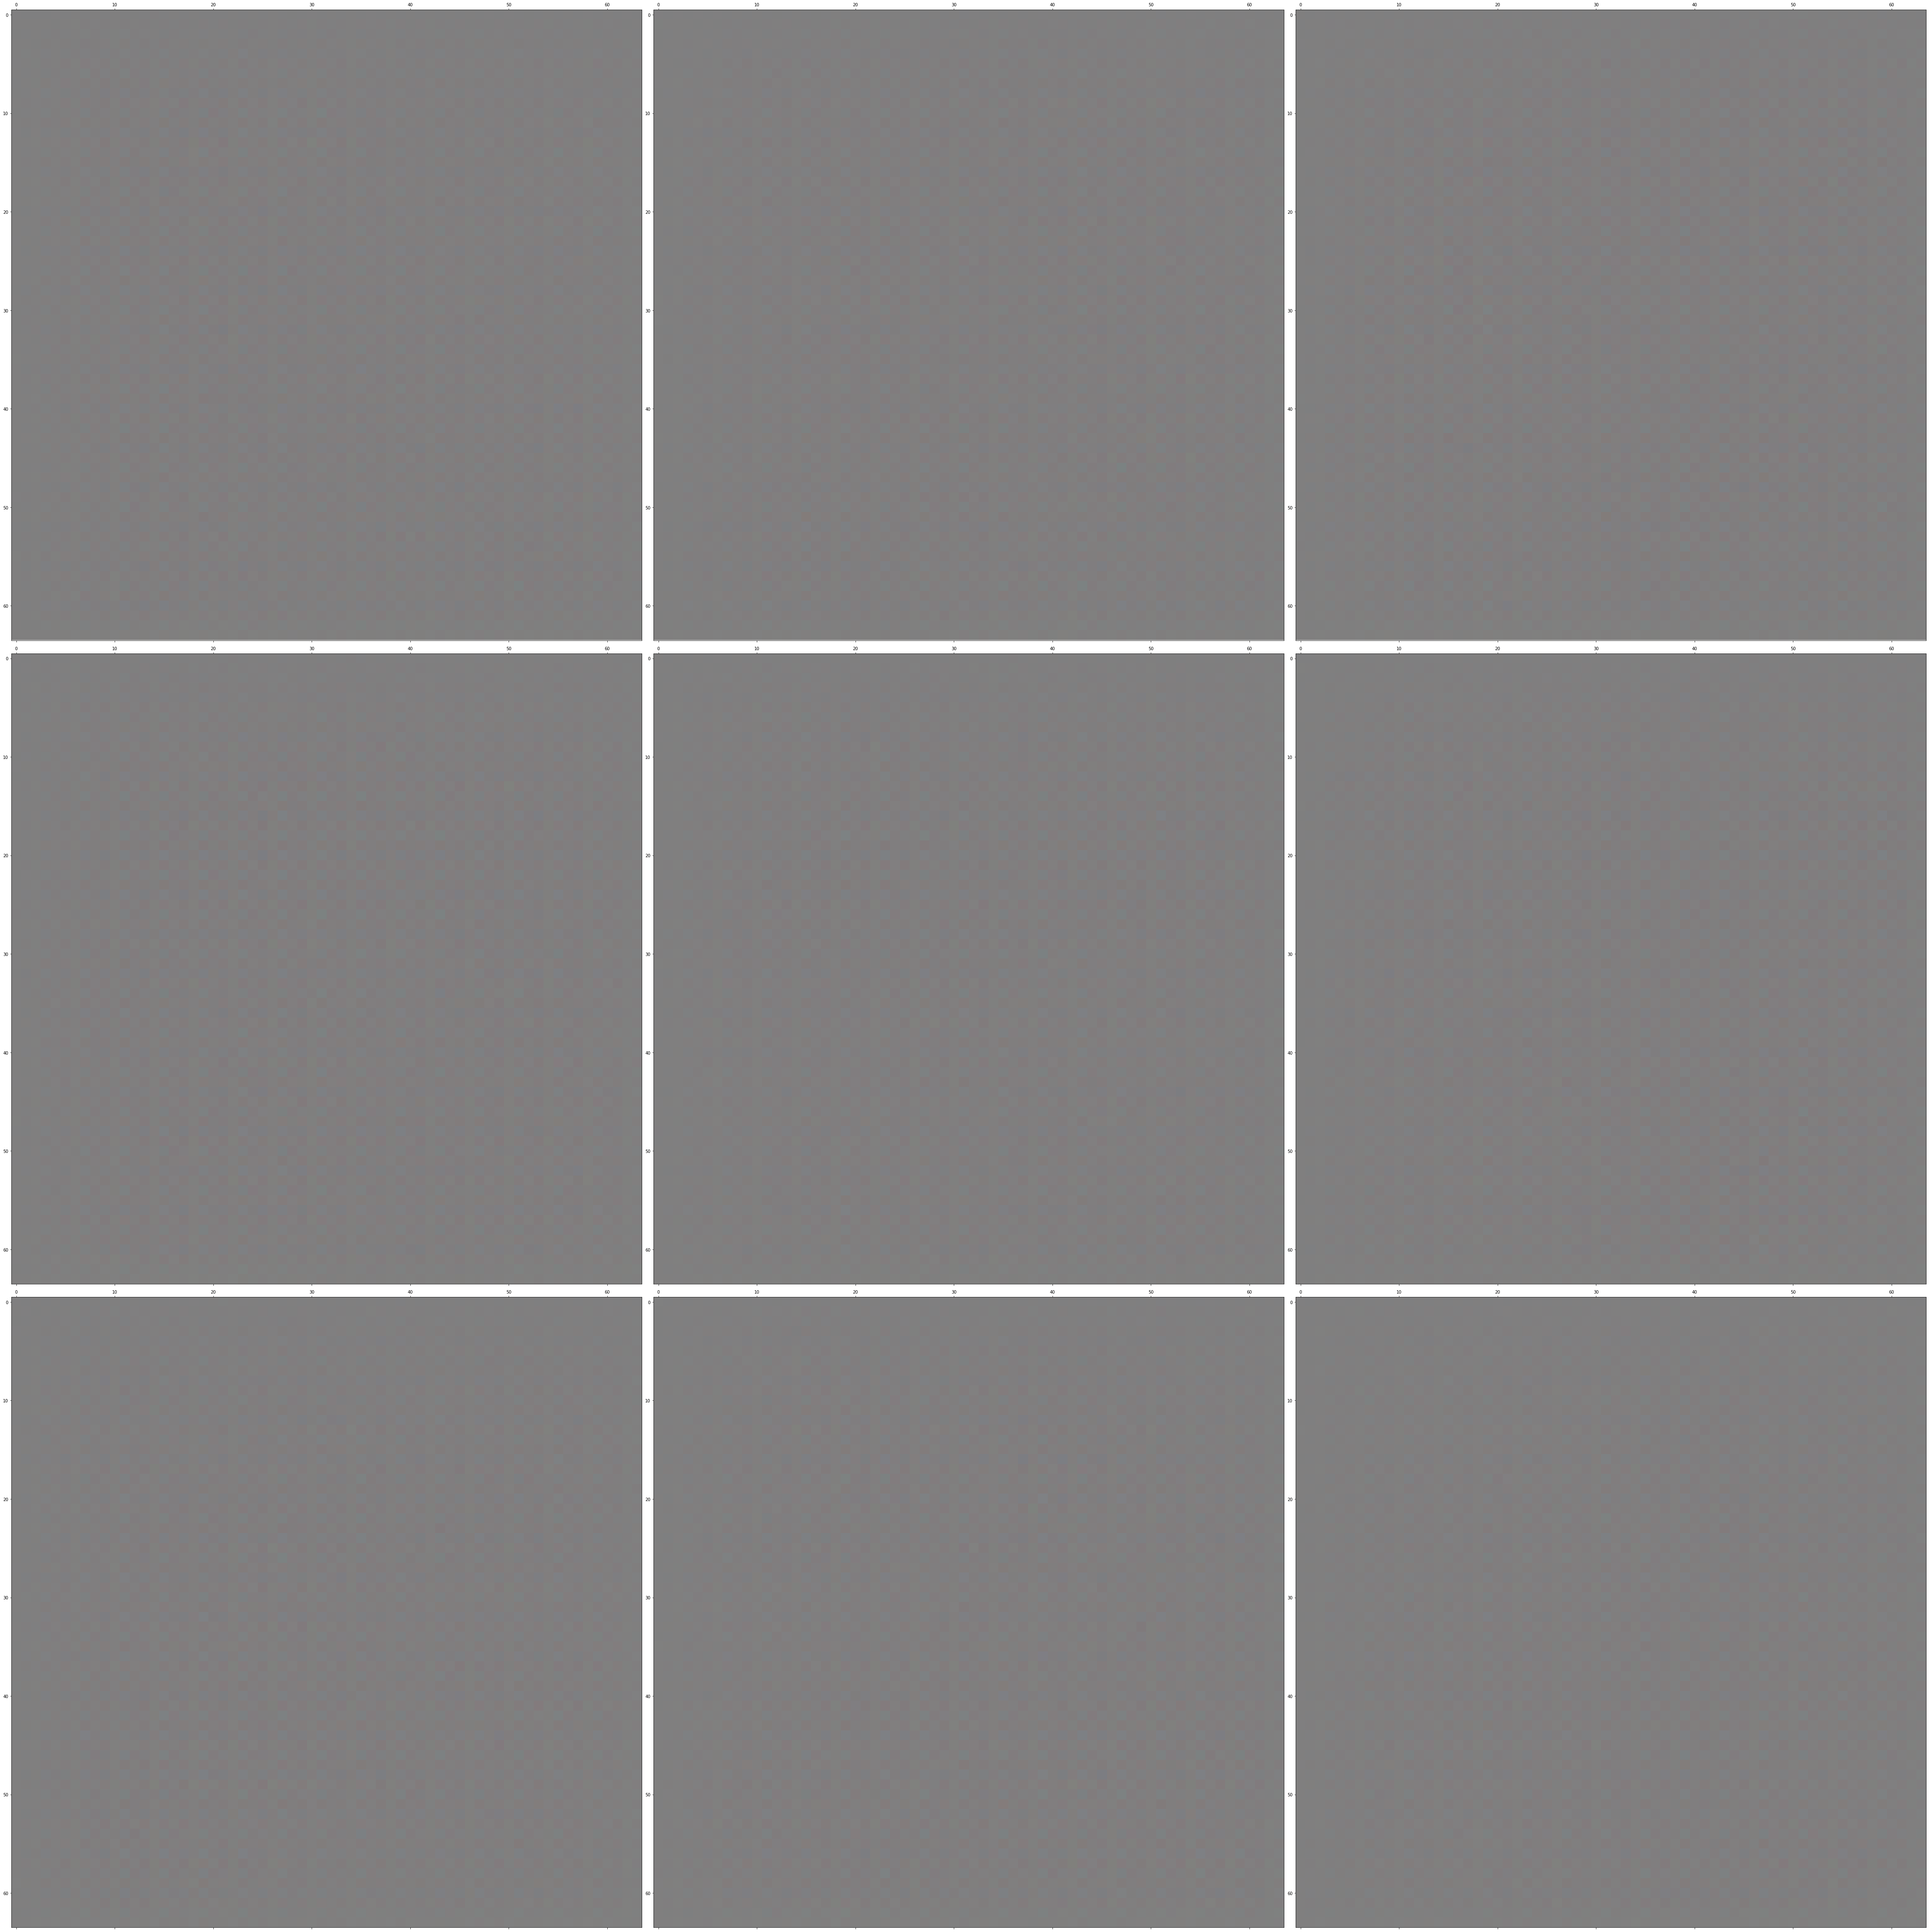

Epoch number:  100
*** Training ***
Discriminator Loss  0.29973670840263367
Generator Loss:  1.4883112907409668
*** Evaluation ***
Discriminator Accuracy on REAL images:  1.0
Discriminator Accuracy on FAKE (generated) images:  0.6000000238418579


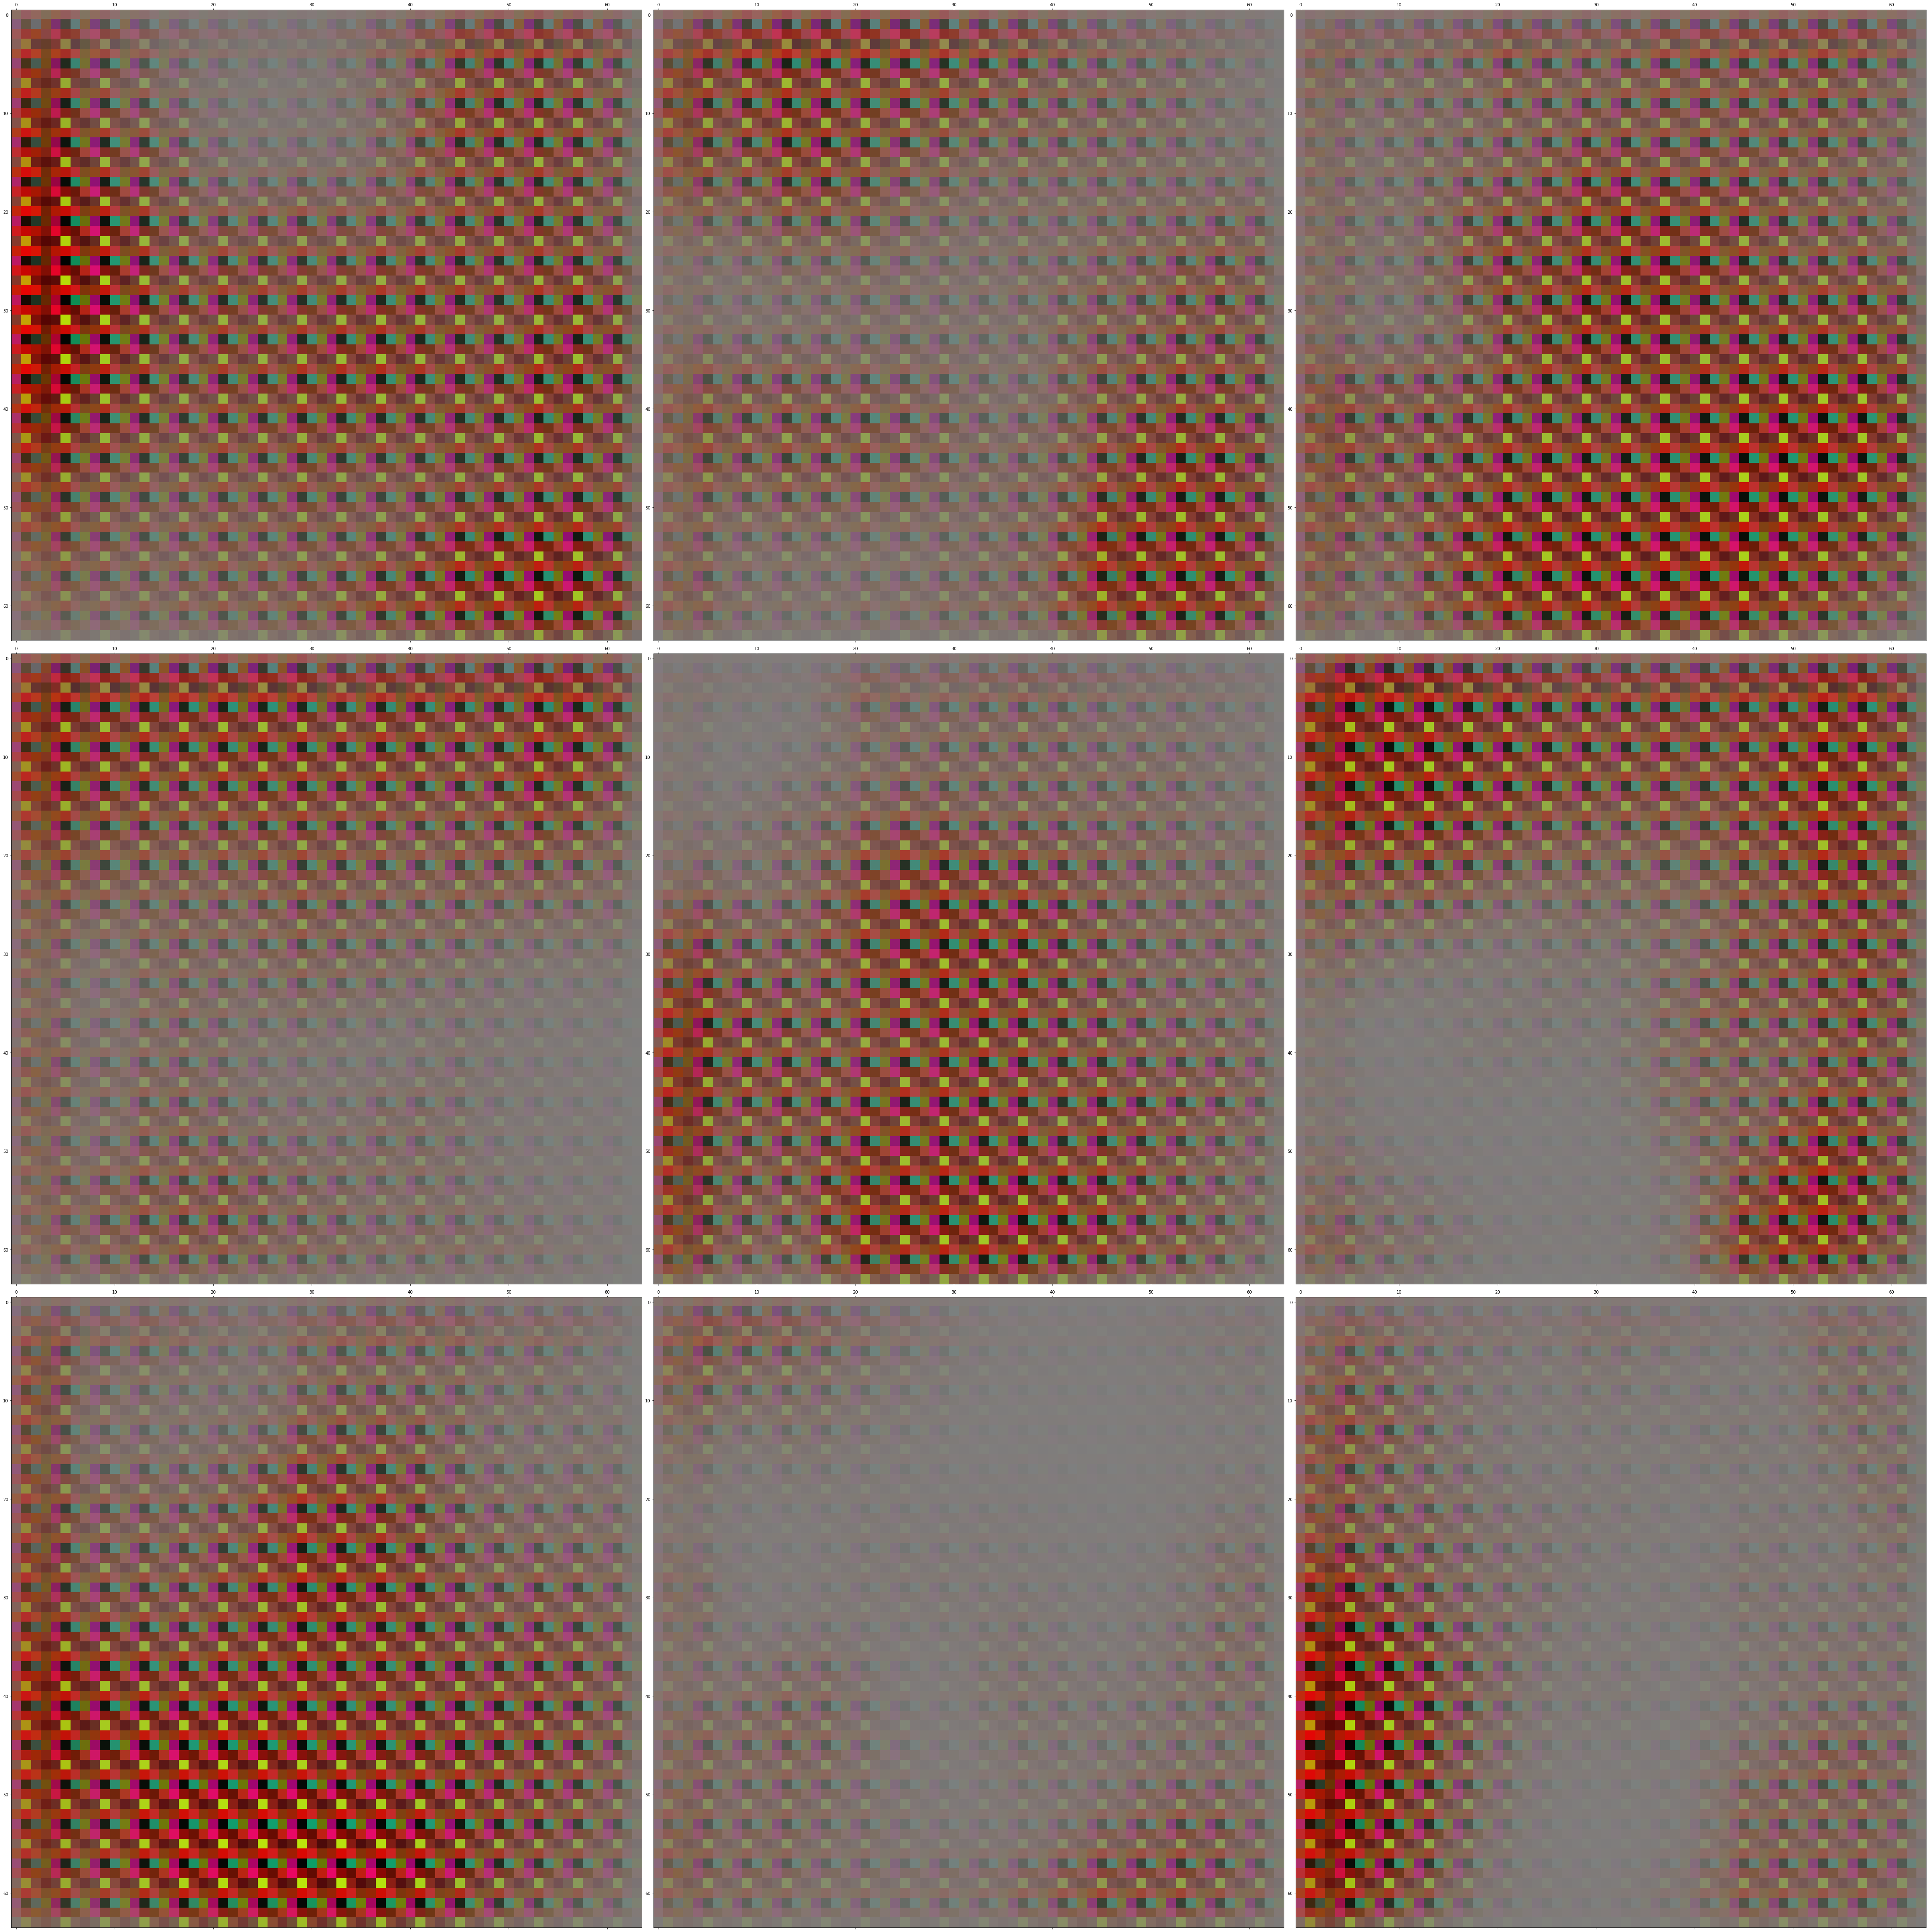

KeyboardInterrupt: 

In [17]:
# Train DCGAN model
train(gen_model, dis_model, gan_model, df_image, seed_size, image_size, BATCH_SIZE, n_epochs)

In [18]:
# Save the current versions of the models (After x epcohs)
gen_model.save(base_path+"/models/007b_Generator.h5")
dis_model.save(base_path+"/models/007b_Discriminator.h5")
gan_model.save(base_path+"/models/007b_GAN.h5")


In [ ]:
# Load saved models
#gen_model_2 = load_model(base_path+"/models/007b_Generator.h5")
#dis_model_2 = load_model(base_path+"/models/007b_Discriminator.h5")
#gan_model_2 = load_model(base_path+"/models/007b_GAN.h5")

In [ ]:
# Train DCGAN model
#train(gen_model_2, dis_model_2, gan_model_2, df_image, seed_size, image_size, BATCH_SIZE, n_epochs)

In [ ]:
# Save the current versions of the models (After x epcohs)
#gen_model_2.save(base_path+"/models/007b_Generator_final.h5")
#dis_model_2.save(base_path+"/models/007b_Discriminator_final.h5")
#gan_model_2.save(base_path+"/models/007b_GAN_final.h5")